In [1]:
import networkx as nx
import time
import pandas as pd
import numpy as np
import stanza

In [2]:
# A sample sentence from biomedical domain is used to demonstrate the approach
sent = 'In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M.'
print (sent, len(sent.split(' ')))

In contrast, the product of the human CDKN2A beta transcript, p14ARF, activates a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M. 32


In [22]:
# Collection of functions that help me process the raw text into a graph using the parsing result.
def spanner(sentence, return_raw=False):
    """ 
    recombine tokens into entity based on 'ner' indicator 
    input: a raw sentence
    output: a stanza Doc object re-tokenized based on combination of terms that are biomedically relevant
    """
    # Using stanford NLP developed Stanza to process the sentence
    # bionlp13cg is a corpus used for NER task on biomedical related text
    pretokenized_nlp = stanza.Pipeline('en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True, verbose=False)
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    
    doc = nlp(sentence)
    cur_ent = []
    tokenized_sent = []
    
    # Recombine tokens based on NER result instead of raw tokens
    for sent in doc.sentences:
        for token in sent.tokens:
            if (token.ner == "O" or token.ner.startswith('S-')):
                tokenized_sent.append(token.text)
            elif token.ner.startswith('B-') or token.ner.startswith('I-'):
                cur_ent.append(token.text)
            elif token.ner.startswith('E-'):
                cur_ent.append(token.text)
                new_span = ' '.join(cur_ent)
                if ' - ' in new_span:
                    new_span = new_span.replace(' - ','-')
                tokenized_sent.append(new_span)
                cur_ent = []
            else:
                pass
    # control the return; whether to return a stanza doc object or raw text
    if return_raw:
        return tokenized_sent, len(tokenized_sent)
    else:
        retokenized_doc = pretokenized_nlp([tokenized_sent])
        return retokenized_doc, len(tokenized_sent)
    
def consolidatedPassSpanner(doc):
    """
    A custom built function to combine certain tokens together
    Currently, there are two basic recombination rules
    1. recombine two consecutive tokens that are both 'NOUN'
    2. recombine two consecutive tokens that are part of the 'VERB' in passive voice
    Input: a stanza doc
    Output: a retokenized stanza doc
    '"""
    retokenized_txt = []
    for sent in doc.sentences:
        count = 0
        while count < len(sent.words):
            if count+1<len(sent.words) and (sent.words[count].upos == 'NOUN' and sent.words[count].xpos=='NN') and (sent.words[count+1].upos=='NOUN' and sent.words[count+1].xpos=='NN'):
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
            elif count+1<len(sent.words) and sent.words[count].upos == 'AUX' and sent.words[count+1].upos=='VERB':
                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
                count +=2
#            elif count+1<len(sent.words) and sent.words[count].upos == 'NOUN' and sent.words[count+1].xpos=='VBP':
#                retokenized_txt.append(' '.join([sent.words[count].text, sent.words[count+1].text]))
#                count +=2
            else:
                retokenized_txt.append(sent.words[count].text)
                count +=1
    return retokenized_txt

def dynamicReSpanner(doc, length):
    """
    A custom built function to recombine tokens using function consolidatedPassSpanner.
    This function will dynamically recombine the tokens based on its last POS tag until there is no
    further feasible recombination.
    """
    pretokenized_biomedicalnlp = stanza.Pipeline(lang='en', package='craft', processors={'ner': 'bionlp13cg'}, tokenize_pretokenized=True, verbose=False) 
    prev_size = length
    while True:
        pretokenized_sent = consolidatedPassSpanner(doc)
        doc = pretokenized_biomedicalnlp([pretokenized_sent])
        next_size = len([word.text for sent in doc.sentences for word in sent.words])
        print ('Prev size: %i Vs. Next size %i' %(prev_size, next_size))
        if next_size == prev_size:
            break
        else:
            prev_size=next_size
    return doc

def spannerWrapper(sent):
    """
    A function to combine the functions "dynamicReSpanner" and "spanner" to allow more complex operation
    on the sentence
    """
    doc_1, length = spanner(sent)
    doc_2 = dynamicReSpanner(doc_1, length)
    return doc_2

def printDoc(doc):
    print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\txpos: {word.xpos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(15, " ") if word.head > 0 else "root"}' for sent in doc.sentences for word in sent.words], sep='\n')


### Extract SVO 

In [4]:
doc_original = spannerWrapper(sent)

Prev size: 35 Vs. Next size 32
Prev size: 32 Vs. Next size 31
Prev size: 31 Vs. Next size 31


In [5]:
printDoc(doc_original)

id: 1	word: In                       	upos: ADP   	xpos: IN    	head: contrast       
id: 2	word: contrast                 	upos: NOUN  	xpos: NN    	head: activates      
id: 3	word: ,                        	upos: PUNCT 	xpos: ,     	head: activates      
id: 4	word: the                      	upos: DET   	xpos: DT    	head: product        
id: 5	word: product                  	upos: NOUN  	xpos: NN    	head: activates      
id: 6	word: of                       	upos: ADP   	xpos: IN    	head: CDKN2A beta transcript
id: 7	word: the                      	upos: DET   	xpos: DT    	head: CDKN2A beta transcript
id: 8	word: human                    	upos: ADJ   	xpos: JJ    	head: CDKN2A beta transcript
id: 9	word: CDKN2A beta transcript   	upos: NOUN  	xpos: NN    	head: product        
id: 10	word: ,                        	upos: PUNCT 	xpos: ,     	head: CDKN2A beta transcript
id: 11	word: p14ARF                   	upos: NOUN  	xpos: NN    	head: CDKN2A beta transcript
id: 12	word: ,   

In [6]:
def generateTokenPairs(doc):
    pairs = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.head>0:
                pairs.append((sent.words[word.head-1].text, word.text))
            else:
                pairs.append(('root', word.text))
    return pairs

def createDAG(pairs):
    h = nx.DiGraph()
    h.add_edges_from(pairs, weight=1)
    return h

import matplotlib.pyplot as plt
%matplotlib inline
def plot_circular_network(graph):
    # A simple function to plot the graph constructed
    #pos = nx.nx_agraph.graphviz_layout(h, prog="twopi", args="")
    plt.figure(figsize=(12, 12))
    pos = nx.circular_layout(h)
    nx.draw(h, pos, node_size=20, alpha=0.5, node_color="blue", with_labels=True)
    plt.axis("equal")
    plt.show()

In [7]:
pairs = generateTokenPairs(doc_original)
h = createDAG(pairs)

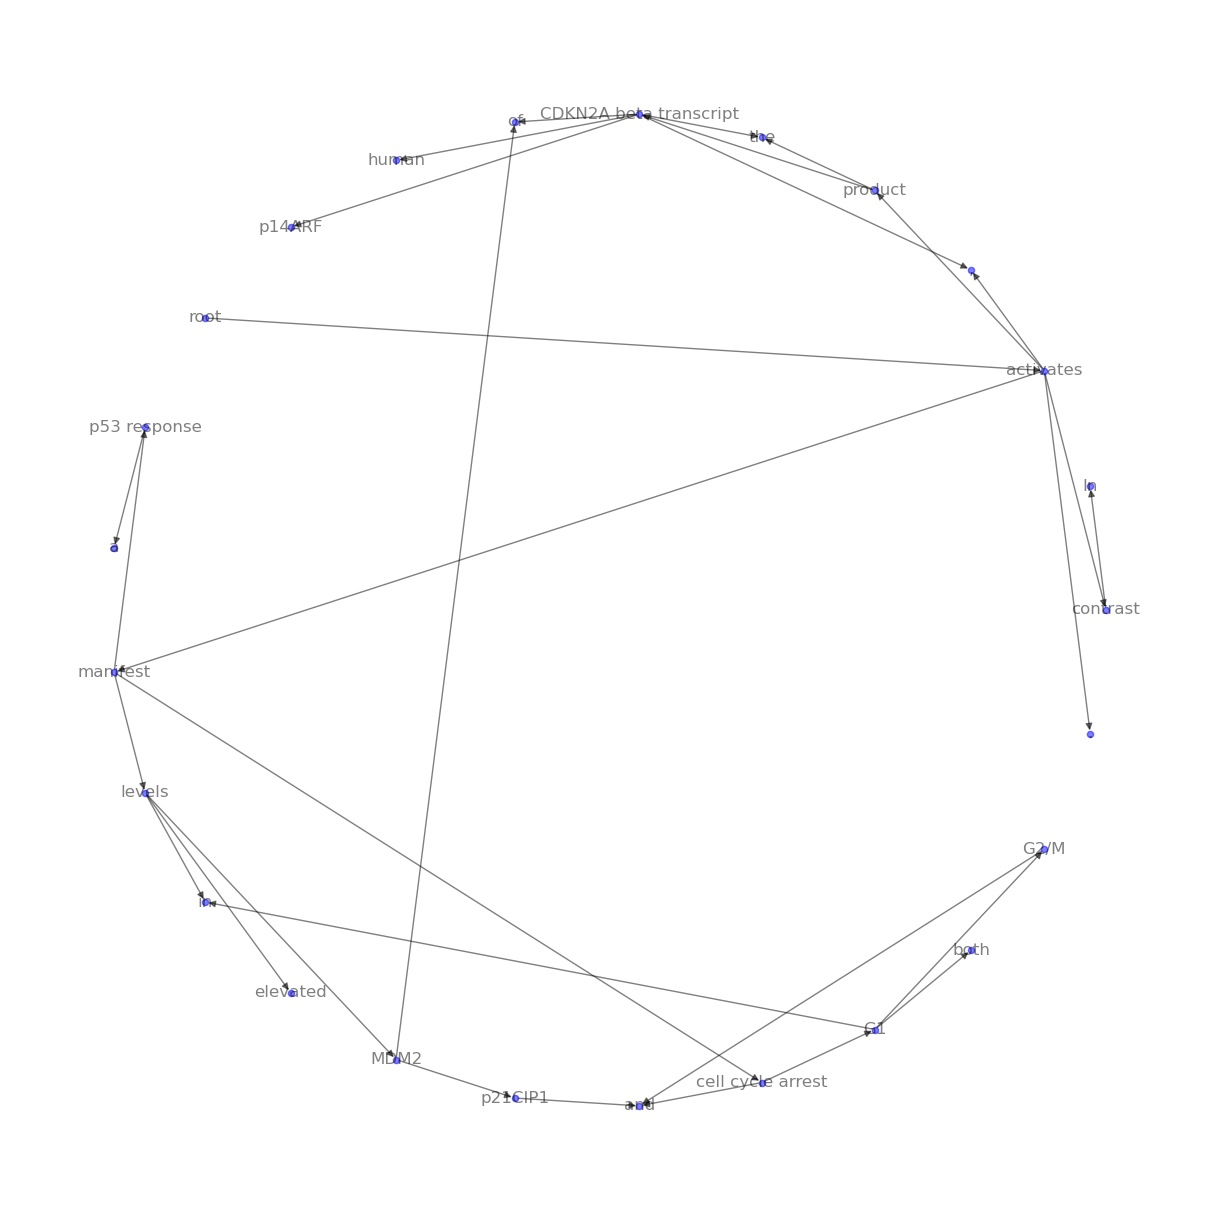

In [8]:
plot_circular_network(h)

<b>Note</b>:

The above diagram shows that 'activates' bisects the sentence into two clear segment and then 'manifest' also bissets the longer remaining segment.  We could make use of this phenomenon to carry out further breakdown.

#### Verb 

In [9]:
def returnRoot(sent):
    """
    Input: a stanza doc
    Output: the root word and its id in the doc object
    """
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    doc = nlp(sent)
    for sent in doc.sentences:
        for word in sent.words:
            if word.head == 0:
                return word.text, word.id

In [10]:
v, ids = returnRoot(sent)
print (v)

activates


#### Subject 

In [11]:
def returnSubjPhrase(sent, ids):
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    doc = nlp(sent)
    subj = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.id<ids:
                subj.append(word.text)
    return ' '.join(subj)      

In [12]:
subj_phrase = returnSubjPhrase(sent,ids)
print(subj_phrase, type(subj_phrase))

In contrast , the product of the human CDKN2A beta transcript , p14ARF , <class 'str'>


In [13]:
doc_s = spannerWrapper(subj_phrase)

Prev size: 13 Vs. Next size 12
Prev size: 12 Vs. Next size 12


In [14]:
printDoc(doc_s)

id: 1	word: In                       	upos: ADP   	xpos: IN    	head: contrast       
id: 2	word: contrast                 	upos: NOUN  	xpos: NN    	head: product        
id: 3	word: ,                        	upos: PUNCT 	xpos: ,     	head: product        
id: 4	word: the                      	upos: DET   	xpos: DT    	head: product        
id: 5	word: product                  	upos: NOUN  	xpos: NN    	head: root
id: 6	word: of                       	upos: ADP   	xpos: IN    	head: CDKN2A beta transcript
id: 7	word: the                      	upos: DET   	xpos: DT    	head: CDKN2A beta transcript
id: 8	word: human                    	upos: ADJ   	xpos: JJ    	head: CDKN2A beta transcript
id: 9	word: CDKN2A beta transcript   	upos: NOUN  	xpos: NN    	head: product        
id: 10	word: ,                        	upos: PUNCT 	xpos: ,     	head: CDKN2A beta transcript
id: 11	word: p14ARF                   	upos: NOUN  	xpos: NN    	head: CDKN2A beta transcript
id: 12	word: ,              

#### Object 

In [15]:
def returnObjPhrase(sent, ids):
    nlp = stanza.Pipeline('en', package='craft', processors={'ner':'bionlp13cg'}, verbose=False)
    doc = nlp(sent)
    obj = []
    for sent in doc.sentences:
        for word in sent.words:
            if word.id>ids:
                obj.append(word.text)
    return ' '.join(obj)

In [16]:
obj_phrase = returnObjPhrase(sent, ids)
print(obj_phrase, type(obj_phrase))

a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M . <class 'str'>


In [17]:
doc_o = spannerWrapper(obj_phrase)

Prev size: 21 Vs. Next size 19
Prev size: 19 Vs. Next size 18
Prev size: 18 Vs. Next size 18


In [18]:
printDoc(doc_o)

id: 1	word: a                        	upos: DET   	xpos: DT    	head: p53 response   
id: 2	word: p53 response             	upos: NOUN  	xpos: NN    	head: manifest       
id: 3	word: manifest                 	upos: VERB  	xpos: VBP   	head: root
id: 4	word: in                       	upos: ADP   	xpos: IN    	head: levels         
id: 5	word: elevated                 	upos: VERB  	xpos: VBN   	head: levels         
id: 6	word: levels                   	upos: NOUN  	xpos: NNS   	head: manifest       
id: 7	word: of                       	upos: ADP   	xpos: IN    	head: MDM2           
id: 8	word: MDM2                     	upos: NOUN  	xpos: NN    	head: levels         
id: 9	word: and                      	upos: CONJ  	xpos: CC    	head: p21CIP1        
id: 10	word: p21CIP1                  	upos: NOUN  	xpos: NN    	head: MDM2           
id: 11	word: and                      	upos: CONJ  	xpos: CC    	head: cell cycle arrest
id: 12	word: cell cycle arrest        	upos: ADJ   	xpos: JJS

<b><i>Note</b></i>:

If we are taking the 'roots' from respective breakdown, we will obtain following 

S (i.e. [...] Product [...]) + V (i.e. activates) + O (i.e. [...] manifest [...])

This follows the English grammer yet a certain term, such as 'Product', is an 'open' container that needs to be clarified for its value and 'manifest' is another verb in a clause.

An approach to fill those open containers is to stop at an Named Entity.

#### Break down Subject and Object further

In [31]:
def preprocessing(sent):
    doc = spannerWrapper(sent)
    root, ids = returnRoot(doc)
    subj = returnSubjPhrase(doc, ids)
    obj = returnObjPhrase(doc, ids)
    return root, ids, subj, obj

In [32]:
root, ids, subj, obj = preprocessing(sent)
root, subj, obj

Prev size: 35 Vs. Next size 32
Prev size: 32 Vs. Next size 31
Prev size: 31 Vs. Next size 31


('activates',
 'In contrast , the product of the human CDKN2A beta transcript , p14ARF ,',
 'a p53 response manifest in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M .')

In [33]:
root, ids, subj, obj = preprocessing(obj)
root, subj, obj

Prev size: 21 Vs. Next size 19
Prev size: 19 Vs. Next size 18
Prev size: 18 Vs. Next size 18


('manifest',
 'a p53 response',
 'in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M .')

In [34]:
root, ids, subj, obj = preprocessing(obj)
root, subj, obj

Prev size: 17 Vs. Next size 16
Prev size: 16 Vs. Next size 15
Prev size: 15 Vs. Next size 15


('levels',
 'in elevated',
 'of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2/M .')

In [35]:
root, ids, subj, obj = preprocessing(obj)
root, subj, obj # give wrong breakdown

Prev size: 14 Vs. Next size 13
Prev size: 13 Vs. Next size 12
Prev size: 12 Vs. Next size 12


('arrest', 'of MDM2 and p21CIP1 and cell cycle', 'in both G1 and G2/M .')

#### Detour: prepositional phrase 

In [39]:
# Retrieve the prepositional phrase from the sample sentence
import spacy
def get_pps(doc):
    "Function to get PPs from a parsed document."
    pps = []
    for token in doc:
        if token.pos_ == 'ADP':
            pp = ' '.join([tok.orth_ for tok in token.subtree])
            pps.append(pp)
    return pps


nlp_sm = spacy.load('en_core_web_sm')
nlp_md = spacy.load('en_core_web_md')
nlp_lg = spacy.load('en_core_web_lg')

nlps = [nlp_sm, nlp_md, nlp_lg]
for nlp in nlps:
    doc = nlp(sent)
    print (get_pps(doc))
    print()

['In contrast', 'of the human CDKN2A beta transcript , p14ARF', 'in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2 / M.', 'of MDM2 and p21CIP1 and cell cycle arrest', 'in both G1 and G2 / M.']

['In contrast', 'of the human CDKN2A beta transcript , p14ARF', 'in elevated levels of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2 / M.', 'of MDM2 and p21CIP1 and cell cycle arrest in both G1 and G2 / M.', 'in both G1 and G2 / M.']

['In contrast', 'of the human CDKN2A beta transcript , p14ARF ,', 'in elevated levels of MDM2 and p21CIP1 and', 'of MDM2 and p21CIP1 and', 'in both G1 and G2 / M.']



In [37]:
neighbors = h.neighbors('product')
for n in neighbors:
    print (n)

the
CDKN2A beta transcript


In [38]:
neighbors = h.neighbors('manifest')
for n in neighbors:
    print (n)

p53 response
levels
cell cycle arrest


<b>Note</b>:

One may notice that these prepositional phrases (PPs) are containing noun chucks that are attached to either subject (i.e. 'product') or object (i.e. 'manifest').  

So it's possible to replace those PPs with a substitute to make the extraction of 'filler' easier.